This notebook visualizes the attention scores from individual attention heads (from the final Transformer block) as [DINO does](https://arxiv.org/abs/2104.14294). 

Code used in this notebook has been copied and modified from the [official DINO implementation](https://github.com/facebookresearch/dino/blob/main/visualize_attention.py). 

## Setup

In [ ]:
!pip install -U gdown -q
!gdown --id 16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
!unzip -q vit_dino_base16.zip

## Imports

In [1]:
import requests
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow import keras
from PIL import Image
from io import BytesIO

## Data utilities

**Notes**

If you're using [DeiT models](https://tfhub.dev/sayakpaul/collections/deit/1) then you should use the same preprocessing utilities. If you're using the original ViT models (mentioned in the main README of this repository) then you should scale the image pixels to [-1, 1] range instead and _not normalize them like the following_. 

In [6]:
input_resolution = 224
patch_size = 16

crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
) 


def preprocess_image(image, size=input_resolution):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / 224) * size)
    image_resized = tf.image.resize(
        image_resized, (resize_size, resize_size), method="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

2022-04-06 16:26:09.881094: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


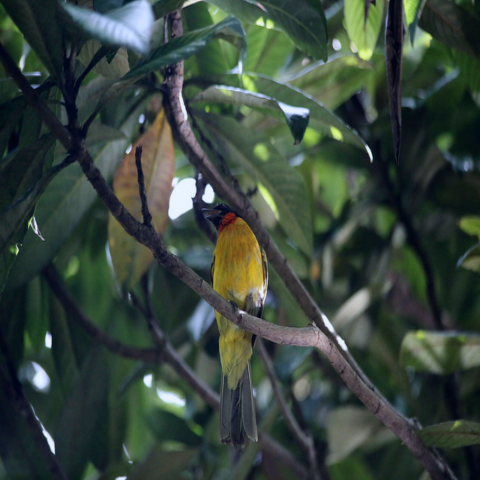

In [5]:
image, preprocessed_image = load_image_from_url(
    "https://dl.fbaipublicfiles.com/dino/img.png"
)
image

## Load the TF DINO model and access the attention scores

In [15]:
tf_dino = tf.keras.models.load_model("vit_dino_base16")

logits, attention_score_dict = tf_dino.predict(preprocessed_image)
print(attention_score_dict.keys())

# Last transformer block.
attention_scores = attention_score_dict["transformer_block_11_att"]
print(attention_scores.shape)

dict_keys(['transformer_block_8_att', 'transformer_block_7_att', 'transformer_block_9_att', 'transformer_block_6_att', 'transformer_block_5_att', 'transformer_block_2_att', 'transformer_block_0_att', 'transformer_block_10_att', 'transformer_block_1_att', 'transformer_block_3_att', 'transformer_block_4_att', 'transformer_block_11_att'])
(1, 12, 197, 197)


## Preprocess the attention scores and visualize them

In [16]:
w_featmap = preprocessed_image.shape[2] // 16
h_featmap = preprocessed_image.shape[1] // 16

nh = attention_scores.shape[1]  # Number of attention heads.

# Taking the representations from CLS token.
attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

# Reshape the attention scores to resemble mini patches.
attentions = attentions.reshape(nh, w_featmap, h_featmap)
print(attentions.shape)

# Resize the attention patches to 224x224 (224: 14x16)
attentions = keras.layers.UpSampling2D(size=16, data_format="channels_first")(
    attentions[None, ...]
)[0]
print(attentions.shape)

(12, 196)
(12, 14, 14)
(12, 224, 224)


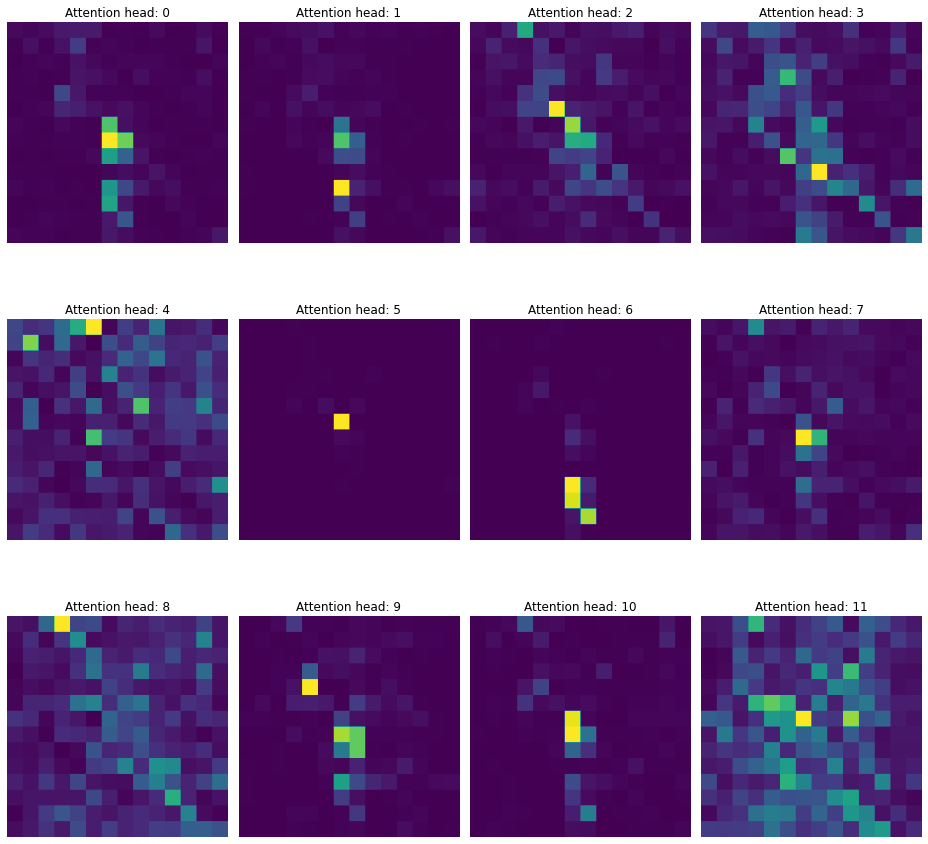

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(attentions[img_count])
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()
fig.savefig("dino_attention_heads", dpi=300, bbox_inches="tight")